In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras import layers as kl
from keras.models import Model
import keras

Using TensorFlow backend.


In [2]:
def extract_x_y(path=None, set_type=None):
    df = pd.read_csv(path)

    if set_type=='train':
        x = df.iloc[:, 1:]
        x = np.array(x).reshape((x.shape[0],28,28,1))
        y = df['label']
        print(x.shape)
        y = keras.utils.np_utils.to_categorical(y.values, num_classes=10)
        return x, y
    else:
        x = df
        x = np.array(x).reshape((x.shape[0],28,28,1))
        print(x.shape)
        return x

In [3]:
X_train, y_train = extract_x_y('train.csv', set_type='train')
X_test = extract_x_y('test.csv', set_type='test')

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, shuffle=True)

In [5]:
[x.shape for x in [X_train, X_val, y_train, y_val]]

[(33600, 28, 28, 1), (8400, 28, 28, 1), (33600, 10), (8400, 10)]

In [18]:
ip = kl.Input(shape=(28,28,1))
x = kl.Conv2D(128, kernel_size=5, activation='relu')(ip)
x = kl.Conv2D(64, kernel_size=3, activation='relu')(x)
x = kl.Conv2D(32, kernel_size=3, activation='relu')(x)
x = kl.Conv2D(16, kernel_size=3, activation='relu')(x)
x = kl.Flatten()(x)
x = kl.Dense(10, activation='softmax')(x)

model = Model(inputs=ip, outputs=x)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       3328      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        73792     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 32)        18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 16)        4624      
_________________________________________________________________
flatten_2 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5185

In [19]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               min_delta=0, patience=10, verbose=0, mode='auto',
                                               baseline=None, restore_best_weights=True)

In [20]:
model.fit(X_train/255, y_train, epochs=30, batch_size=64, validation_split=0.2, 
          callbacks=[early_stopping])
#model.fit(X_train/255, y_train, epochs=30, batch_size=64, validation_split=0.2, )

Train on 26880 samples, validate on 6720 samples
Epoch 1/30
26880/26880 [==============================] - 7s 264us/step - loss: 0.2165 - accuracy: 0.9339 - val_loss: 0.1326 - val_accuracy: 0.9610
Epoch 2/30
26880/26880 [==============================] - 7s 258us/step - loss: 0.0699 - accuracy: 0.9798 - val_loss: 0.0715 - val_accuracy: 0.9772
Epoch 3/30
26880/26880 [==============================] - 7s 260us/step - loss: 0.0489 - accuracy: 0.9846 - val_loss: 0.0632 - val_accuracy: 0.9812
Epoch 4/30
26880/26880 [==============================] - 7s 258us/step - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0877 - val_accuracy: 0.9812
Epoch 5/30
26880/26880 [==============================] - 7s 260us/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 0.0532 - val_accuracy: 0.9857
Epoch 6/30
26880/26880 [==============================] - 7s 262us/step - loss: 0.0211 - accuracy: 0.9929 - val_loss: 0.0623 - val_accuracy: 0.9823
Epoch 7/30
26880/26880 [==============================] - 7s 26

In [21]:
y_val_pred = model.predict(X_val/255).argmax(axis=1)

In [22]:
metrics.confusion_matrix(y_val.argmax(axis=1), y_val_pred)

array([[838,   0,   1,   0,   0,   1,   0,   0,   1,   0],
       [  0, 935,   2,   1,   3,   0,   1,   1,   1,   0],
       [  2,   1, 839,   9,   0,   0,   0,   7,   2,   1],
       [  1,   0,   8, 857,   0,   1,   0,   1,   0,   1],
       [  1,   3,   0,   0, 805,   0,   3,   1,   2,   8],
       [  0,   1,   2,   2,   3, 732,   4,   0,   1,   2],
       [  3,   0,   0,   0,   1,   2, 824,   0,   0,   0],
       [  0,   6,   4,   1,   2,   0,   0, 796,   1,   2],
       [  2,   0,   5,   5,   1,   0,   1,   2, 811,   4],
       [  2,   1,   2,   3,   8,   3,   0,   6,   1, 816]], dtype=int64)

In [23]:
metrics.accuracy_score(y_val.argmax(axis=1), y_val_pred)

0.9825

In [24]:
false_predictions = X_val[y_val_pred != y_val.argmax(axis=1)]
false_labels      = y_val_pred[y_val_pred != y_val.argmax(axis=1)]
true_labels       = y_val[y_val_pred != y_val.argmax(axis=1)].argmax(axis=1)

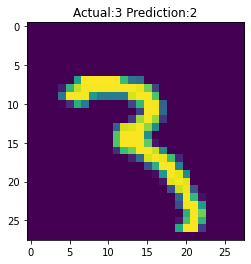

In [25]:
n = np.random.randint(false_predictions.shape[0])
plt.imshow(false_predictions[n])
plt.title("Actual:{} Prediction:{}".format(true_labels[n], false_labels[n]))
plt.show()

In [26]:
y_test = model.predict(X_test/255).argmax(axis=1)

In [27]:
sol = pd.DataFrame({'ImageId':np.arange(1,len(y_test)+1), 'Label':y_test}, columns=['ImageId', 'Label'])
sol.to_csv('submission.csv', index=False)